In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"DEIN_USERNAME","key":"DEIN_API_KEY"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download joebeachcapital/30000-spotify-songs
!unzip 30000-spotify-songs.zip


Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs
License(s): DbCL-1.0
100% 3.00M/3.01M [00:00<00:00, 25.0MB/s]
100% 3.01M/3.01M [00:00<00:00, 22.9MB/s]
Archive:  30000-spotify-songs.zip
  inflating: readme.md               
  inflating: spotify_songs.csv       


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

In [3]:
# EDA
import pandas as pd

df = pd.read_csv('spotify_songs.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [4]:
print(df.playlist_genre.unique())
print(df.playlist_subgenre.unique())

['pop' 'rap' 'rock' 'latin' 'r&b' 'edm']
['dance pop' 'post-teen pop' 'electropop' 'indie poptimism' 'hip hop'
 'southern hip hop' 'gangster rap' 'trap' 'album rock' 'classic rock'
 'permanent wave' 'hard rock' 'tropical' 'latin pop' 'reggaeton'
 'latin hip hop' 'urban contemporary' 'hip pop' 'new jack swing'
 'neo soul' 'electro house' 'big room' 'pop edm'
 'progressive electro house']


In [5]:
# check empty

print(df.isnull().sum())
df = df.dropna()

track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64


In [6]:
print(df.dtypes)

track_id                     object
track_name                   object
track_artist                 object
track_popularity              int64
track_album_id               object
track_album_name             object
track_album_release_date     object
playlist_name                object
playlist_id                  object
playlist_genre               object
playlist_subgenre            object
danceability                float64
energy                      float64
key                           int64
loudness                    float64
mode                          int64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_ms                   int64
dtype: object


In [7]:
df = df.drop(columns=[
    "track_id", "track_name", "track_artist", "track_album_id",
    "track_album_name", "track_album_release_date", "playlist_name", "playlist_id",
    "playlist_subgenre"
])


In [8]:
df.columns

Index(['track_popularity', 'playlist_genre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms'],
      dtype='object')

In [9]:
from scipy.stats import f_oneway, kruskal
import pandas as pd

# Konvertiere Genres in numerische Labels
df["genre_label"], _ = pd.factorize(df["playlist_genre"])

# Liste der numerischen Features
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numerical_features.remove("genre_label")  # Zielvariable entfernen

# Berechne die F-Statistik für jedes numerische Feature
feature_scores = {}
for feature in numerical_features:
    groups = [df[df["genre_label"] == g][feature] for g in df["genre_label"].unique()]
    stat, p = f_oneway(*groups)
    feature_scores[feature] = p  # Niedrigere p-Werte = wichtigere Features

# P-Werte für jedes Feature anzeigen
for feature, p_value in sorted(feature_scores.items(), key=lambda x: x[1]):
    print(f"{feature}: p-value = {p_value:.10f}")

# Sortiere die Features nach Signifikanz
important_features = sorted(feature_scores, key=feature_scores.get)[:10]
print("Top 10 wichtigste numerische Features:", important_features)


danceability: p-value = 0.0000000000
energy: p-value = 0.0000000000
loudness: p-value = 0.0000000000
speechiness: p-value = 0.0000000000
acousticness: p-value = 0.0000000000
instrumentalness: p-value = 0.0000000000
valence: p-value = 0.0000000000
duration_ms: p-value = 0.0000000000
track_popularity: p-value = 0.0000000000
tempo: p-value = 0.0000000000
mode: p-value = 0.0000000000
liveness: p-value = 0.0000000000
key: p-value = 0.0008878489
Top 10 wichtigste numerische Features: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'duration_ms', 'track_popularity', 'tempo']


In [10]:
#Relevant features

features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
            'instrumentalness', 'valence', 'duration_ms', 'track_popularity', 'tempo']

X = df[features]
y = df["genre_label"]  # Numerische Labels für Genres

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [11]:
#normalize
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [12]:
#PyTorch Tensor

#turn into Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.long)

#Dataset
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

#Dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [13]:
# input & Output
input_size = X_train.shape[1]
hidden_size = 256 # 64 too small for 10 input features
output_size = len(np.unique(y))

# MLP - Modell mit 4 verborgenen Schichten
class GenreClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)  # Erste Schicht mit 512 Neuronen
        self.bn1 = nn.BatchNorm1d(512)         # BatchNorm für die erste Schicht
        self.fc2 = nn.Linear(512, 256)        # Zweite Schicht mit 256 Neuronen
        self.bn2 = nn.BatchNorm1d(256)        # BatchNorm für die zweite Schicht
        self.fc3 = nn.Linear(256, 128)        # Dritte Schicht mit 128 Neuronen
        self.bn3 = nn.BatchNorm1d(128)        # BatchNorm für die dritte Schicht
        self.fc4 = nn.Linear(128, 64)         # Vierte Schicht mit 64 Neuronen
        self.bn4 = nn.BatchNorm1d(64)         # BatchNorm für die vierte Schicht
        self.fc5 = nn.Linear(64, output_size) # Ausgabeschicht
        self.dropout = nn.Dropout(0.3)        # Dropout mit 30%

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))      # Aktivierungsfunktion für erste Schicht
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))      # Aktivierungsfunktion für zweite Schicht
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))      # Aktivierungsfunktion für dritte Schicht
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc4(x)))      # Aktivierungsfunktion für vierte Schicht
        x = self.dropout(x)
        x = F.log_softmax(self.fc5(x), dim=1)  # LogSoftmax für die Ausgabeschicht
        return x


#Initalize Modell
model = GenreClassifier()

In [14]:
# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

In [15]:
# Early stopping-Parameter
best_val_loss = np.inf
patience = 8     # number of epochs w/o improvement before training stops
patience_counter = 0

# Training

num_epochs = 50
train_losses = []
val_losses = []
best_acc = 0
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0

# training loop
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)       # forward loop
        loss = criterion(outputs, labels)  # loss
        loss.backward()   # backpropagation
        optimizer.step()    # Optimization
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validierung
    model.eval()
    epoch_val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    accuracy = 100 * correct / total

    #Early Stopping-Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

    #LR Scheduler
    scheduler.step(avg_val_loss)

    #Early stopping with accuracy
    if accuracy > best_acc:
      best_acc = accuracy
      patience_counter = 0
      torch.save(model.state_dict(), 'best_model.pth')
    else:
      patience_counter += 1

# Show all 10 Epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.2f}%")


Epoch [10/50] - Train Loss: 1.3146, Val Loss: 1.2671, Val Acc: 54.46%
Early stopping triggered at epoch 16.


In [16]:
# Modell Evaluation

from sklearn.metrics import accuracy_score

# Testdaten vorbereiten
X_test_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Vorhersagen machen
model.eval()  # Modell in Evaluierungsmodus versetzen (Deaktiviert Dropout / BatchNorm, falls vorhanden)
with torch.no_grad():
    predictions = model(X_test_tensor).argmax(dim=1)  # Höchster Wert = vorhergesagte Klasse

# Genauigkeit berechnen
accuracy = accuracy_score(y_test_tensor, predictions)
print(f'Genauigkeit des Modells auf den Testdaten: {accuracy:.4f}')


Genauigkeit des Modells auf den Testdaten: 0.5536


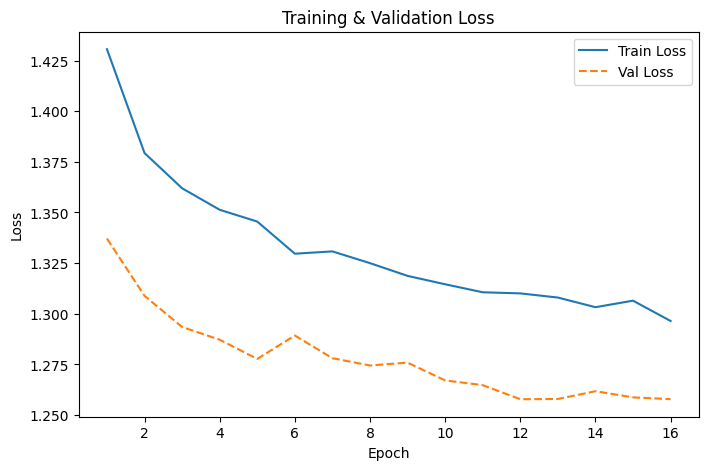

In [17]:
plt.figure(figsize=(8, 5))
epochs_completed = len(train_losses)  # Tatsächliche Anzahl der trainierten Epochen
plt.plot(range(1, epochs_completed + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs_completed + 1), val_losses, label="Val Loss", linestyle="dashed")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()